# BioImageIT: experiment data processing

In this tutorial, we are going to write a pipeline for batch processing data stored in an `experiment`. **BioImageIT** comes with a class called `Pipeline`. This class run on an `experiment`. We add a sequence of precesses on the pipeline class and run the processes on data selected by simple queries.

## The experiment

In this tutorial, we will use the same experiment than the one created in the *tutorial1-experiment*. The experiment goal is explained in the *tutorial1*. As a reminder, we have two populations of images contained spots in noisy images. In this tutorial, we are going to segment and count the spots, and then run a statistical test to conclude if the two population have significantly different number of spots. 

In [1]:
# BioImageIT core import and initialisation

from bioimageit_core.config import ConfigAccess
from bioimageit_core.process import ProcessAccess
from bioimageit_formats import FormatsAccess
ConfigAccess('../config.json') 
FormatsAccess(ConfigAccess.instance().get('formats')['file'])

In [2]:
# in this cell we create the experiment, import and anotate data
from bioimageit_core.experiment import Experiment

# create the experiment
my_experiment = Experiment()
my_experiment.create(name="myexperiment", 
                     author="Sylvain Prigent", 
                     uri="../workspace/") 

# import the data
my_experiment.import_dir(dir_uri='./synthetic_data/data/',
                         filter_=".*\.tif$",
                         author='Sylvain Prigent', 
                         format_='imagetiff', 
                         date='2019-03-17', 
                         directory_tag_key='')

# tag population
my_experiment.tag_from_name("Population", ['population1', 'population2'] )
# tag ID
my_experiment.tag_using_seperator(tag="ID", separator="_", value_position=1) 

my_experiment.display()

--------------------
Experiment: 
	Name:  myexperiment
	Author:  Sylvain Prigent
	Created:  2021-12-02
	Tags: 
		- Population
		- ID
	DataSet:  data
+-----------------+-------------+-----+-----------------+--------------+
|       Name      |  Population |  ID |      Author     | Created date |
+-----------------+-------------+-----+-----------------+--------------+
| population1_001 | population1 | 001 | Sylvain Prigent |  2019-03-17  |
| population1_015 | population1 | 015 | Sylvain Prigent |  2019-03-17  |
| population1_014 | population1 | 014 | Sylvain Prigent |  2019-03-17  |
| population1_016 | population1 | 016 | Sylvain Prigent |  2019-03-17  |
| population1_002 | population1 | 002 | Sylvain Prigent |  2019-03-17  |
| population1_003 | population1 | 003 | Sylvain Prigent |  2019-03-17  |
| population1_017 | population1 | 017 | Sylvain Prigent |  2019-03-17  |
| population1_013 | population1 | 013 | Sylvain Prigent |  2019-03-17  |
| population1_007 | population1 | 007 | Sylvain 

## The Pipeline class

The **BioImagePy** pipeline module contains the main class `Pipeline`. It's the only class we are going to use to process the data. Let's look the module documentation: 

In [3]:
import bioimageit_core.pipeline as pipelinepy

help(pipelinepy)

Help on module bioimageit_core.pipeline in bioimageit_core:

NAME
    bioimageit_core.pipeline - pipeline module.

DESCRIPTION
    This module contains the Pipeline class that allows to design a pipeline
    to process data contained in an Experiment 
    
    Example
    -------
        Here is an example of how to write a Pipeline:
    
            >>> from bioimageit_core.experiment import Experiment
            >>> from bioimageit_core.pipeline import Pipeline
            >>> 
            >>> mypipeline = Pipeline(Experiment('my/experiment/uri'))
            >>>
            >>> p1 = mypipeline.add_process('svdeconv2d')
            >>> p1.set_parameters('sigma', '3', 'weighting', '0.1', 'regularization', '2')
            >>> p1.add_input('i', 'data', '')
            >>> p1.set_dataset_name('deconv2d')
            >>>
            >>> p2 = mypipeline.add_process('particleanalyzer')
            >>> p2.set_parameters('threshold', 'Default dark')
            >>> p2.add_input('i', 'deconv

### Initialize the pipeline 


In [4]:
from bioimageit_core.pipeline import Pipeline
pipeline = Pipeline(my_experiment)


## Processing

In the following of this tutorial, we are going to process the data in 3 steps.
1. Image deconvolution on each image to ease the spot segmentation
2. Auto thresholding and particle analysis on the deconvolutes images
3. Statistical testing with the wilcoxon test to conclude if the two population have significantly different number of spots

The 3 proposed steps are just one possible way to analyse the data, to illustrate the use of BioImagePy. Many other processing workflow are possible to analyse this dataset, but it is not the purpose of this tutorial.

### Step 1: image deconvolution

To make the spot segmentation easier to identify, we chose to preprocess the data with a deconvolution algorithm. The selected algorithm is the SVDeconv2D implemented in c++. It is available in **BioImagePy** with the ID `svdeconv2d_v0.1.0`. 

We thus add a process with the name `svdeconv2d_v0.1.0`. To setup the process we need 3 methods:
1. `set_parameters` to set the all the process parameters as pairs name, value list
2. `set_dataset_name` to set the name of the dataset where the outputs will be stored. This method is not mandatory. If you do not use it, the process name will be used as a default dataset name
3. `add_input` for each input of the process. Here we have only one input 'i' the input image, and we set it to the dataset `data` with an empty filter in order to process all the data in the raw dataset called `data`

Finally we call the `run` method to run the process

In [7]:
# visualize the inputs and parameters of the svdeconv2d process
svdeconv2d = ProcessAccess().get('spitfiredeconv2d_v0.1.2')
svdeconv2d.man()

SPITFIR(e) 2D : 
	              i	               	    Input Image
	          sigma	            1.5	          Sigma
	 regularization	             12	 Regularization
	      weighting	            0.6	      Weighting
	         method	             HV	         Method
	        padding	               	        Padding
	              o	               	 Denoised image


In [8]:
from bioimageit_formats import FormatsAccess
print(FormatsAccess.instance().get('imagetiff'))

In [9]:
# run the process
process1 = pipeline.add_process(svdeconv2d)
process1.set_parameters('sigma', 4, 'regularization', 12, 'weighting', 0.1, 'method', 'SV', 'padding', True)
process1.set_dataset_name('deconv')
process1.add_input('i', 'data')
process1.run()

experiment at: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/experiment.md.json
create the processed dataset at: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/processeddataset.md.json
/Users/sprigent/BioimageIT/miniconda3
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_001.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner cmd shell split: ['simgspitfiredeconv2d', '-i', '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_001.tif', '-o', '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif', '-sigma', '4', '-regularization', '12', '-weighting', 

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_002.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_002_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 146 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_003_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_003.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_003_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_006.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_006_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 153 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_012_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_012.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_012_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_005.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_005_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 145 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_016_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_016.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_016_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_001.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_001_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 162 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_015_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_015.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_015_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_011.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_011_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 140 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_005_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_005.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_005_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_012.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_012_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 159 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_020_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_020.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_020_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population2_018.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_018_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 147 ms 
save float image 128, 128, 1
output arg name =  o
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_020_o.tif
runner cmd:         simgspitfiredeconv2d -i '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_020.tif' -o '/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_020_o.tif' -sigma '4' -regularization '12' -weighting '0.1' -method 'SV' -padding 'True' -niter 200    
runner

spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/data/population1_018.tif
spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_018_o.tif
spitfire2d: method: SV
spitfire2d: regularization parameter: 12.000000
spitfire2d: weighting parameter: 0.100000
spitfire2d: nb iterations: 200
spitfire2d: use padding
Use 8 threads
                                                                      | 100 %
Elapsed time: 0 seconds 142 ms 
save float image 128, 128, 1


Let visualize the obtained results:

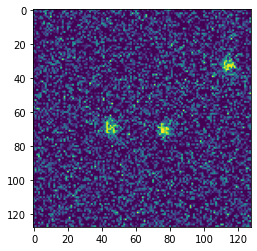

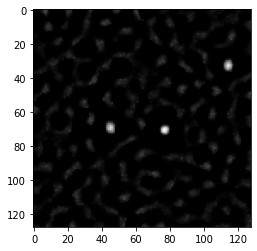

In [10]:
from bioimageit_core.data import ProcessedData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get one processeddata and it origin raw data
processed_data = ProcessedData(my_experiment.get_data('deconv', 'Population=population1 AND ID=001')[0])
origin_data = processed_data.get_origin()

# plot the origin data
img=mpimg.imread(origin_data.metadata.uri)
imgplot = plt.imshow(img)
plt.show()

# plot the processed data
img=mpimg.imread(processed_data.metadata.uri)
imgplot = plt.imshow(img)
plt.show()

### Step 2: Image segmentation

In this step, we apply an automatique threshold and a particle analysis in each images in order to obtain the number of spots in each images.

The selected algorithm is a Fiji macro that runs an auto-threshold and the analyse particles tool. It is available in **BioImagePy** with the ID `threshold_particles_v1.0.0`. 

We can then run it the same way that the previous process:

In [11]:
# visualize the inputs and parameters of the svdeconv2d process
threshold_particles = ProcessAccess().get('threshold_particles_v1.0.0')
threshold_particles.man()

Count particles : 
	          input	               	    Input image
	      threshold	   Default dark	Threshold method
	           draw	               	Particles drawing
	          count	               	Number of particles
	       measures	               	Particles measures


In [15]:
# run the process
process2 = pipeline.add_process(threshold_particles)
process2.set_parameters('threshold', 'Minimum')
process2.set_dataset_name('particles3')
process2.add_input('input', 'deconv')
process2.run()

experiment at: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/experiment.md.json
create the processed dataset at: /Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/processeddataset.md.json
output arg name =  draw
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_draw.tif
output arg name =  count
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_count.csv
output arg name =  measures
output arg value =  /Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_measures.csv
runner cmd:         '/Users/sprigent/BioImageIT/Fiji.app/Contents/MacOS/ImageJ-macosx' --headless --console -macro "threshold_particles.ijm" ['/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif','Minimum','/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_draw.tif

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_001_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_001_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_015_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_015_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_015_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_015_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_014_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_014_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_014_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_014_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_016_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_016_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_016_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_016_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_002_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_002_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_002_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_002_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_003_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_003_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_003_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_003_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_017_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_017_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_017_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_017_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_013_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_013_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_013_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_013_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_007_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_007_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_007_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_007_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_006_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_006_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_006_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_006_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_012_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_012_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_012_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_012_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_004_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_004_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_004_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_004_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_010_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_010_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_010_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_010_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_011_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_011_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_011_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_011_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_005_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_005_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_005_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_005_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_016_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_016_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_016_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_016_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_002_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_002_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_002_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_002_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_003_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_003_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_003_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_003_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_017_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_017_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_017_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_017_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_001_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_001_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_001_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_001_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_015_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_015_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_015_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_015_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_014_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_014_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_014_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_014_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_004_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_004_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_004_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_004_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_010_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_010_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_010_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_010_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_011_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_011_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_011_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_011_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_005_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_005_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_005_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_005_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_013_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_013_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_013_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_013_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_007_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_007_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_007_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_007_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_006_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_006_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_006_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_006_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_012_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_012_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_012_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_012_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_020_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_020_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_020_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_020_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_008_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_008_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_008_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_008_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_009_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_009_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_009_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_009_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_019_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_019_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_019_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_019_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_018_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_018_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population2_018_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population2_018_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_020_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_020_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_020_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_020_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_008_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_008_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_008_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_008_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_009_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_009_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_009_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_009_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_019_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_019_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_019_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_019_o_d

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_018_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_measures.csv]
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_018_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_measures.csv
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/deconv/population1_018_o.tif
Minimum
/Users/sprigent/Documents/bioimageit/workspace/myexperiment/particles3/population1_018_o_d

### Step 3: Statistical test

In the previous step, the segmentation algorithm calulated the number of spots for each images. Then, we now need to perform a statistical test to measure if the spot number is statistically different for the two populations.

We will use the Wilcoxon test available in **BioImagePy** using the `wilcoxon.xml` wrapper. 


In [16]:
process3 = pipeline.add_process(ProcessAccess().get('Wilcoxon_v1.0.0'))
process3.set_dataset_name('wilcoxon')
process3.add_input('x', 'particles', 'Population=population1', 'count')
process3.add_input('y', 'particles', 'Population=population2', 'count')
process3.run()

TypeError: expected str, bytes or os.PathLike object, not NoneType

With the code above, the Wilcoxon test has been performed between *population1* and *population2* using the result `count` of the process `Count_partices`. 

Because the `Wilcoxon_v1.0.0` process works on merged data, we do not need to 'manualy' merge the results in an array files since **BioImagePy** do it for us.

Now we can read the results of the Wicoxon test:

In [11]:
wilcoxon_pvalue_file = ProcessedData(my_experiment.get_data('wilcoxon', 'name=p')[0]).metadata.uri

with open(wilcoxon_pvalue_file, 'r') as content_file:
    p = content_file.read()    
print('p-value=', p)    

p-value= 0.002190093964928984
